In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim #优化
import numpy as np
import matplotlib.pyplot as plt #绘图
import torchvision #加载图片
from torchvision import transforms #图片变换

In [2]:
#对数据做归一化（-1，1）
transform=transforms.Compose([
    #将shanpe为（H,W，C）的数组或img转为shape为（C,H,W）的tensor
    transforms.ToTensor(), #转为张量并归一化到【0，1】；数据只是范围变了，并没有改变分布
    transforms.Normalize(0.5,0.5)#数据归一化处理，将数据整理到[-1,1]之间；可让数据呈正态分布
])

In [3]:
#下载数据到指定的文件夹
train_ds = torchvision.datasets.MNIST('/home/dhz/MNIST/',
                                      train=True,
                                     transform=transform,
                                     download=True)

In [4]:
train_ds

Dataset MNIST
    Number of datapoints: 60000
    Root location: /home/dhz/MNIST/
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=0.5, std=0.5)
           )

In [4]:
dataloader=torch.utils.data.DataLoader(train_ds,batch_size=64,shuffle=True)

In [5]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator,self).__init__()
        self.main=nn.Sequential(
        nn.Linear(100,256),
        nn.ReLU(),
        nn.Linear(256,512),
        nn.ReLU(),
        nn.Linear(512,784),
        nn.Tanh()#对于生成器，最后一个激活函数是tanh,值域：-1到1
        )
    #定义前向传播 
    def forward(self,x):  #x表示长度为100的noise输入
        img = self.main(x)
        img=img.view(-1,28,28)#转换成图片的形式
        return img

In [1]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator,self).__init__()
        self.main = nn.Sequential(
        nn.Linear(784,512),
        nn.LeakyReLU(),
        nn.Linear(512,256),
        nn.LeakyReLU(),
        nn.Linear(256,1),
        nn.Sigmoid()
        )
    def forward(self,x):
        x =x.view(-1,784) #展平
        x =self.main(x)
        return x

NameError: name 'nn' is not defined

In [7]:
#设备的配置
device='cuda' if torch.cuda.is_available() else 'cpu'

In [8]:
#初始化生成器和判别器把他们放到相应的设备上
gen = Generator().to(device)
dis = Discriminator().to(device)

In [9]:
#训练器的优化器
d_optim = torch.optim.Adam(dis.parameters(),lr=0.0001)
#训练生成器的优化器
g_optim = torch.optim.Adam(dis.parameters(),lr=0.0001)

In [10]:
#交叉熵损失函数
loss_fn = torch.nn.BCELoss()

In [11]:
def gen_img_plot(model,test_input):
    prediction = np.squeeze(model(test_input).detach().cpu().numpy())
    fig = plt.figure(figsize=(4,4))
    for i in range(16):
        plt.subplot(4,4,i+1)
        plt.imshow((prediction[i]+1)/2)
        plt.axis('off')
    plt.show()

In [12]:
test_input = torch.randn(16,100 ,device=device) #16个长度为100的随机数

In [13]:
D_loss = []
G_loss = []

Epoch: 0


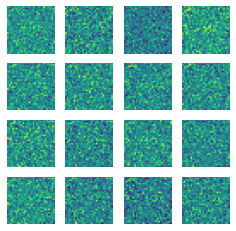

Epoch: 1


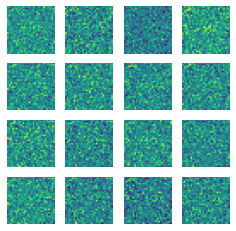

Epoch: 2


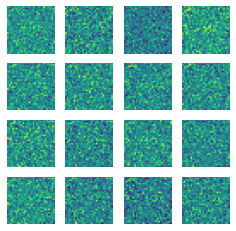

Epoch: 3


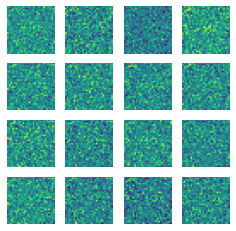

Epoch: 4


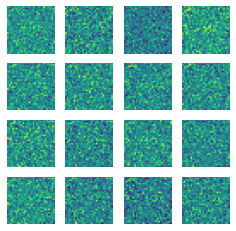

Epoch: 5


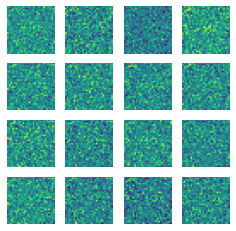

Epoch: 6


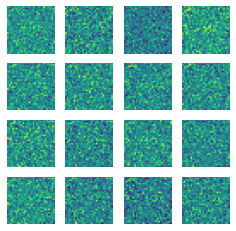

Epoch: 7


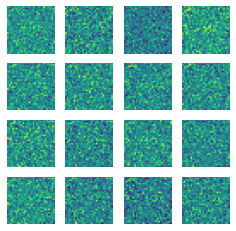

Epoch: 8


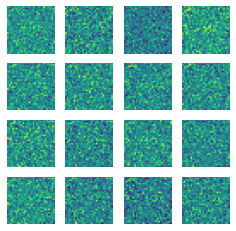

Epoch: 9


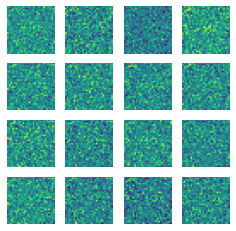

Epoch: 10


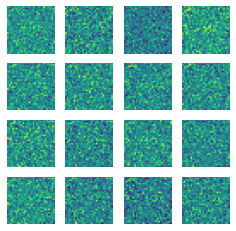

Epoch: 11


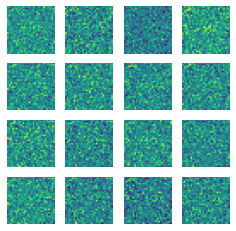

Epoch: 12


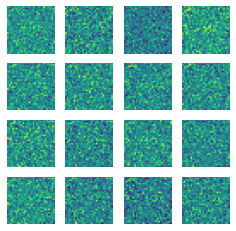

Epoch: 13


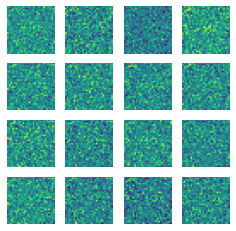

Epoch: 14


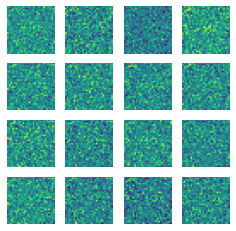

Epoch: 15


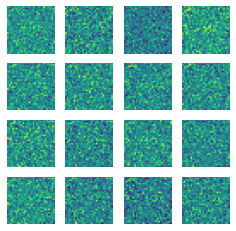

Epoch: 16


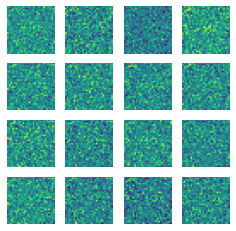

Epoch: 17


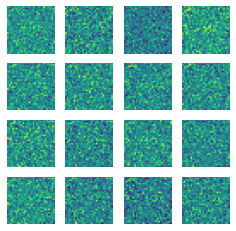

Epoch: 18


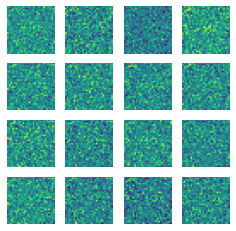

Epoch: 19


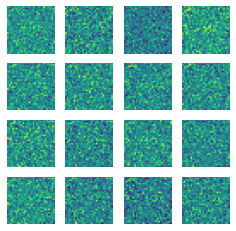

In [14]:
#训练循环
for epoch in range(20):
    #初始化损失值
    d_epoch_loss = 0
    g_epoch_loss = 0
    count = len(dataloader) #返回批次数
    #对数据集进行迭代
    for step,(img,_) in enumerate(dataloader):
        img =img.to(device) #把数据放到设备上
        size = img.size(0) #img的第一位是size,获取批次的大小
        random_noise = torch.randn(size,100,device=device)
        
        #判别器训练(真实图片的损失和生成图片的损失),损失的构建和优化
        d_optim.zero_grad()#梯度归零
        #判别器对于真实图片产生的损失
        real_output = dis(img) #判别器输入真实的图片，real_output对真实图片的预测结果
        d_real_loss = loss_fn(real_output,
                              torch.ones_like(real_output)
                              )
        d_real_loss.backward()#计算梯度
        
        #在生成器上去计算生成器的损失，优化目标是判别器上的参数
        gen_img = gen(random_noise) #得到生成的图片
        #因为优化目标是判别器，所以对生成器上的优化目标进行截断
        fake_output = dis(gen_img.detach()) #判别器输入生成的图片，fake_output对生成图片的预测;detach会截断梯度，梯度就不会再传递到gen模型中了
        #判别器在生成图像上产生的损失
        d_fake_loss = loss_fn(fake_output,
                              torch.zeros_like(fake_output)
                              )
        d_fake_loss.backward()
        #判别器损失
        d_loss = d_real_loss + d_fake_loss
        #判别器优化
        d_optim.step()
        
        
        #生成器上损失的构建和优化
        g_optim.zero_grad() #先将生成器上的梯度置零
        fake_output = dis(gen_img)
        g_loss = loss_fn(fake_output,
                              torch.ones_like(fake_output)
                          )  #生成器损失
        g_loss.backward()
        g_optim.step()
        #累计每一个批次的loss
        with torch.no_grad():
            d_epoch_loss +=d_loss
            g_epoch_loss +=g_loss
    #求平均损失
    with torch.no_grad():
            d_epoch_loss /=count
            g_epoch_loss /=count
            D_loss.append(d_epoch_loss)
            G_loss.append(g_epoch_loss)
            print('Epoch:',epoch)
            gen_img_plot(gen,test_input)

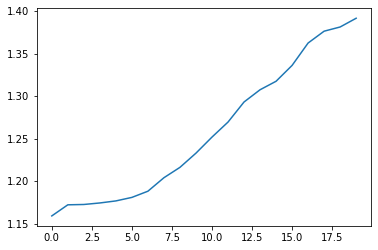

In [15]:
plt.plot(D_loss)

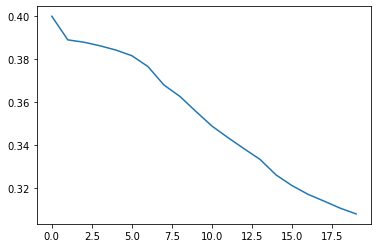

In [16]:
plt.plot(G_loss)

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),     # 归一化为0~1
    transforms.Normalize(0.5,0.5) # 归一化为-1~1
])
train_ds = torchvision.datasets.MNIST('/home/dhz/MNIST/',  # 下载到那个目录下
                                      train=True,
                                      transform=transform,
                                      download=True)
dataloader = torch.utils.data.DataLoader(train_ds, batch_size=64,shuffle=True)
imgs,_ = next(iter(dataloader))
imgs.shape
# torch.Size([64, 1, 28, 28])

torch.Size([64, 1, 28, 28])

In [3]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__() # 继承父类
        self.main = nn.Sequential(
            nn.Linear(100,256), nn.ReLU(),
            nn.Linear(256,512), nn.ReLU(),
            nn.Linear(512,28*28), 
            nn.Tanh()  # 最后必须用tanh，把数据分布到（-1，1）之间
        )
    def forward(self, x):  # x表示长度为100的噪声输入
        img = self.main(x)
        img = img.view(-1,28,28,1) # 方便等会绘图
        return img

In [4]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator,self).__init__()
        self.main = nn.Sequential(
            nn.Linear(28*28,512),
            nn.LeakyReLU(), # x小于零是是一个很小的值不是0，x大于0是还是x
            nn.Linear(512,256),
            nn.LeakyReLU(),
            nn.Linear(256,1),
            nn.Sigmoid() # 保证输出范围为（0，1）的概率
        )
    def forward(self, x): # x表示28*28的mnist图片
        img = x.view(-1,28*28)
        img = self.main(img)
        return img

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('training on ',device)
# 模型
gen = Generator().to(device)
dis = Discriminator().to(device)
# 优化器
g_opt = torch.optim.Adam(gen.parameters(),lr=0.0001)
d_opt = torch.optim.Adam(dis.parameters(),lr=0.0001)
# 损失
loss = torch.nn.BCELoss()

training on  cuda


In [6]:
def gen_img_plot(model, test_input):
    prediction = np.squeeze(model(test_input).detach().cpu().numpy())
    fig = plt.figure(figsize=(4,4))
    for i in range(16):
        plt.subplot(4,4,i+1) # 四行四列的第一个
        # imshow函数绘图的输入是（0，1）的float，或者（1，256）的int
        # 但prediction是tanh出来的范围是[-1，1]没法绘图，需要转成0~1(即加1除2)。
        plt.imshow( (prediction[i]+1)/2 )
        plt.axis('off')
    plt.show()
test_input = torch.randn(16, 100, device=device)

Epoch:  0


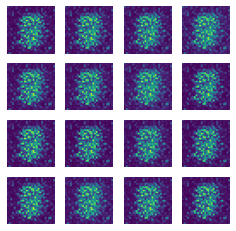

Epoch:  1


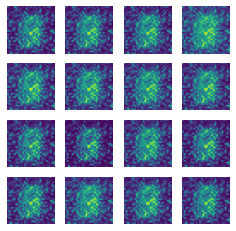

Epoch:  2


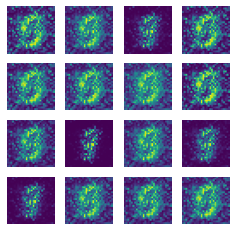

Epoch:  3


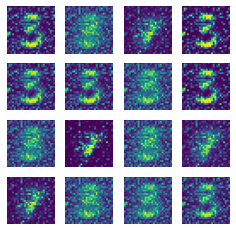

Epoch:  4


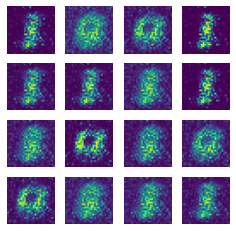

Epoch:  5


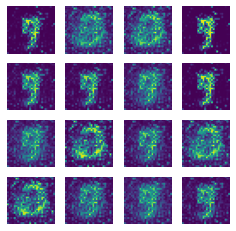

Epoch:  6


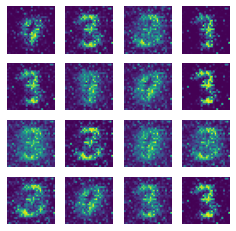

Epoch:  7


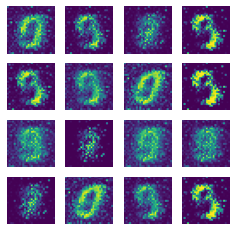

Epoch:  8


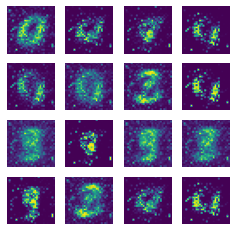

Epoch:  9


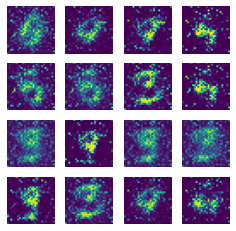

Epoch:  10


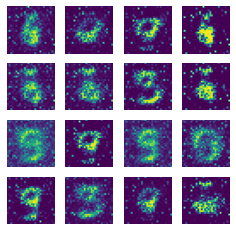

Epoch:  11


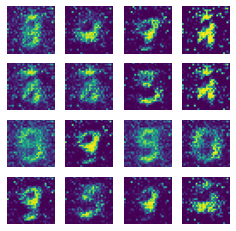

Epoch:  12


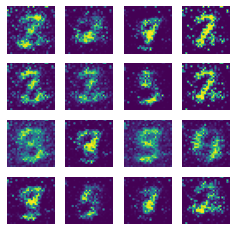

Epoch:  13


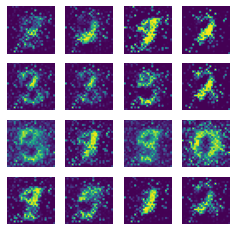

Epoch:  14


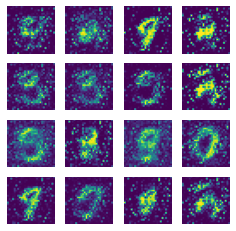

Epoch:  15


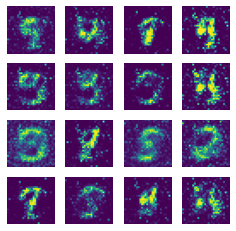

Epoch:  16


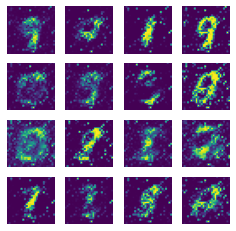

Epoch:  17


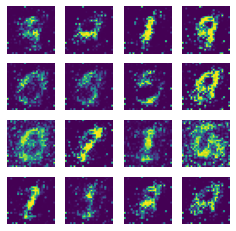

Epoch:  18


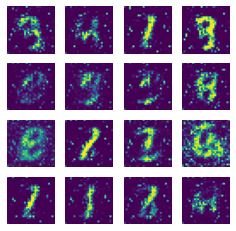

Epoch:  19


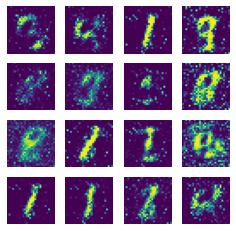

Epoch:  20


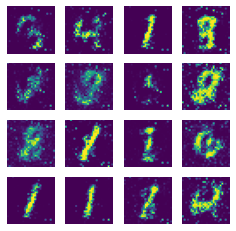

Epoch:  21


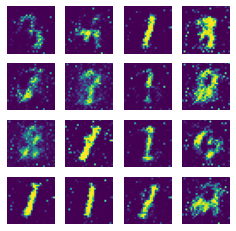

Epoch:  22


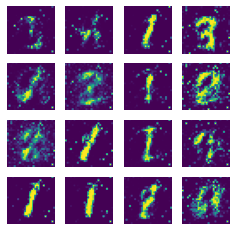

Epoch:  23


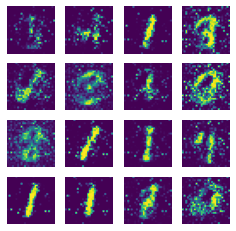

Epoch:  24


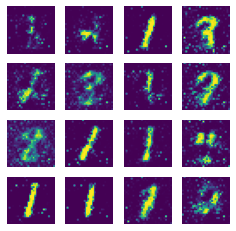

Epoch:  25


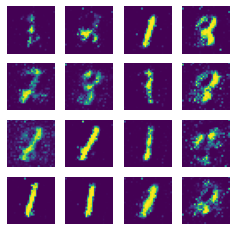

Epoch:  26


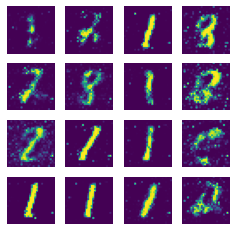

Epoch:  27


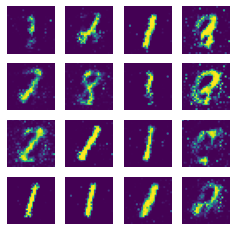

Epoch:  28


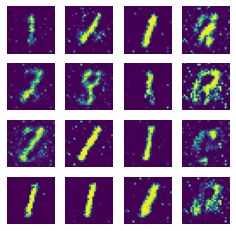

Epoch:  29


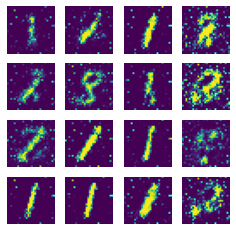

Epoch:  30


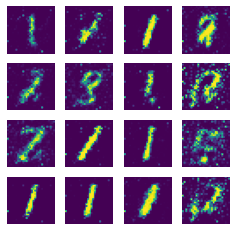

Epoch:  31


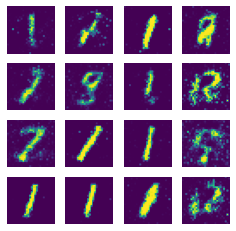

Epoch:  32


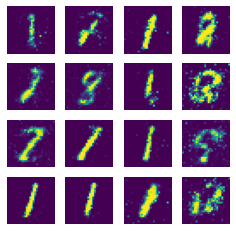

Epoch:  33


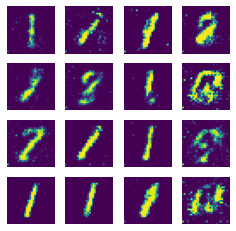

Epoch:  34


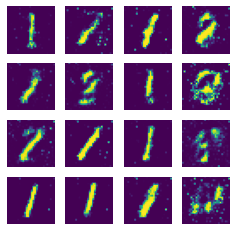

Epoch:  35


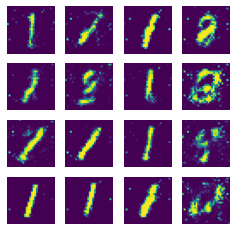

Epoch:  36


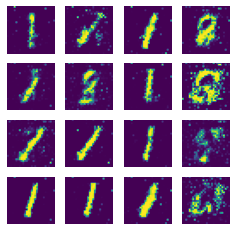

Epoch:  37


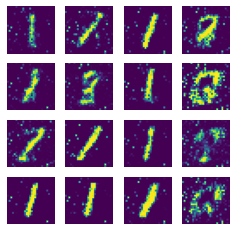

Epoch:  38


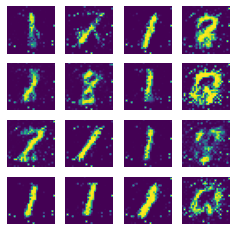

Epoch:  39


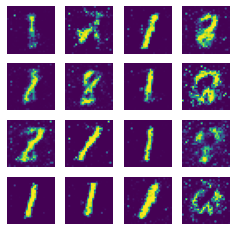

Epoch:  40


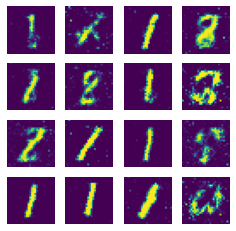

Epoch:  41


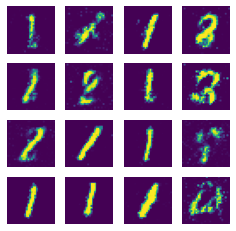

Epoch:  42


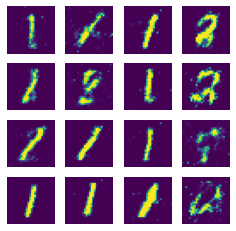

Epoch:  43


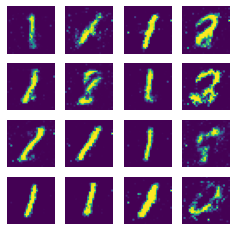

Epoch:  44


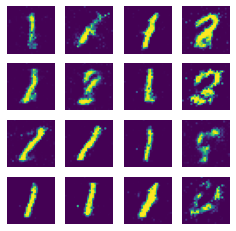

Epoch:  45


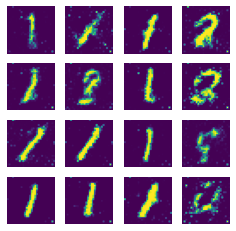

Epoch:  46


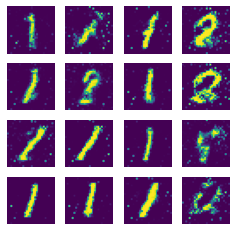

Epoch:  47


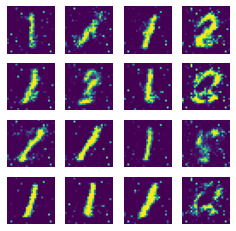

Epoch:  48


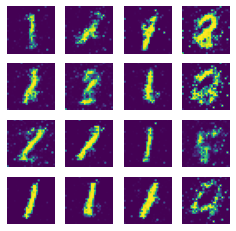

Epoch:  49


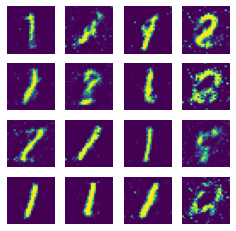

Epoch:  50


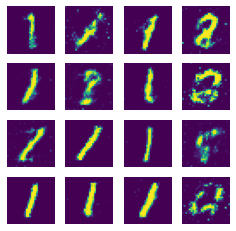

Epoch:  51


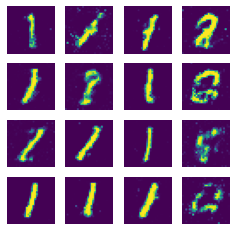

Epoch:  52


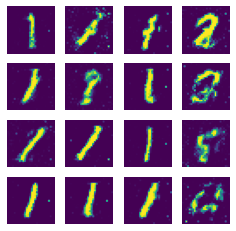

Epoch:  53


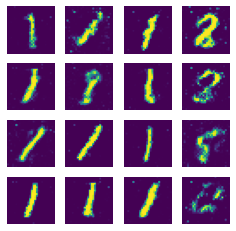

Epoch:  54


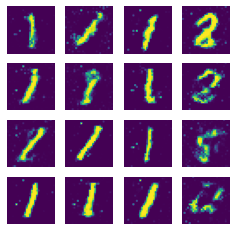

Epoch:  55


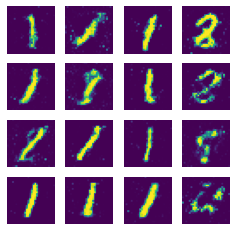

Epoch:  56


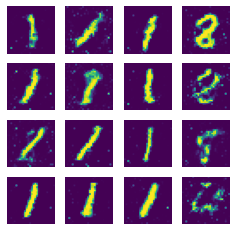

Epoch:  57


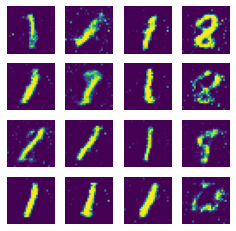

Epoch:  58


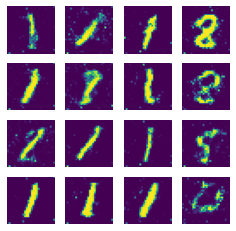

Epoch:  59


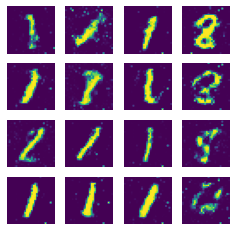

Epoch:  60


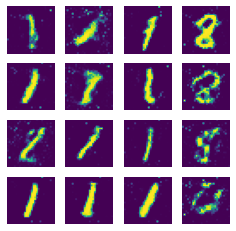

Epoch:  61


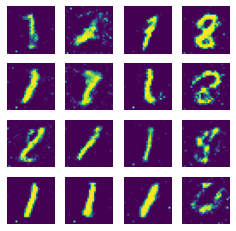

Epoch:  62


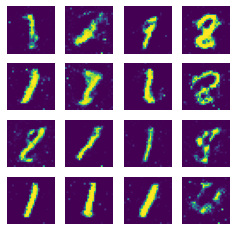

Epoch:  63


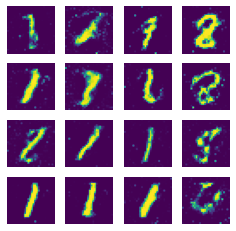

Epoch:  64


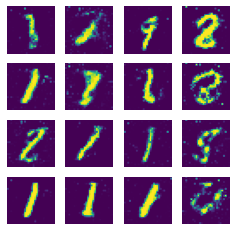

Epoch:  65


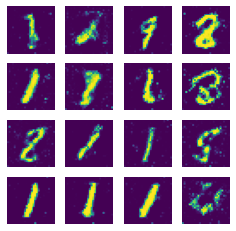

Epoch:  66


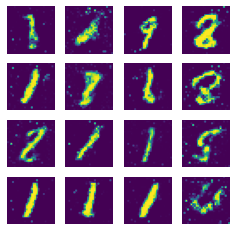

Epoch:  67


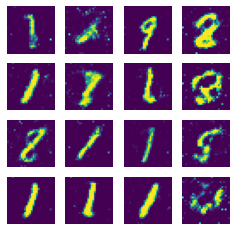

Epoch:  68


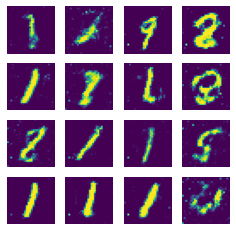

Epoch:  69


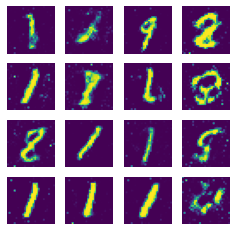

Epoch:  70


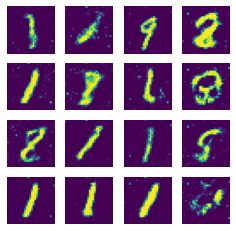

Epoch:  71


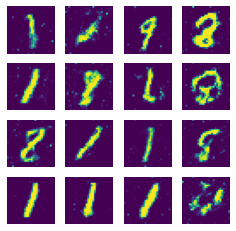

Epoch:  72


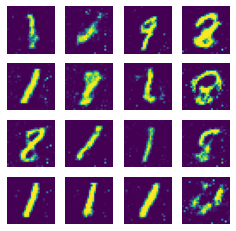

Epoch:  73


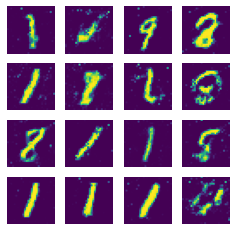

Epoch:  74


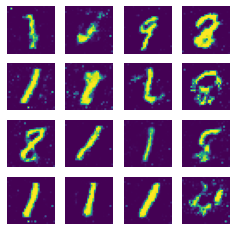

Epoch:  75


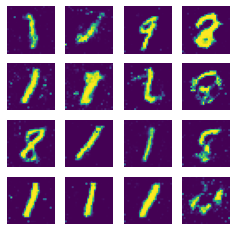

Epoch:  76


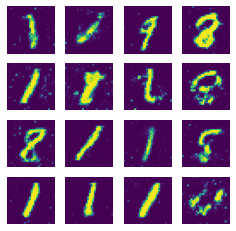

Epoch:  77


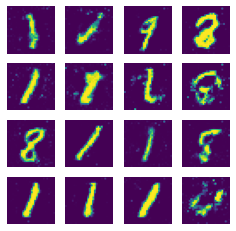

Epoch:  78


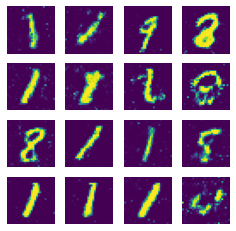

Epoch:  79


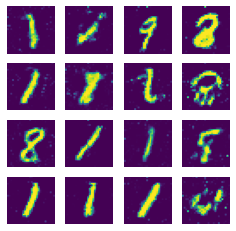

Epoch:  80


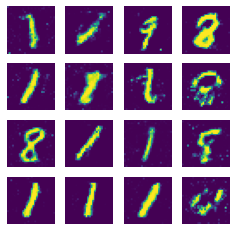

Epoch:  81


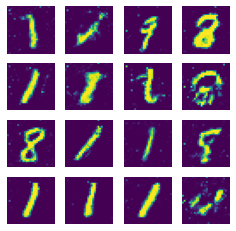

Epoch:  82


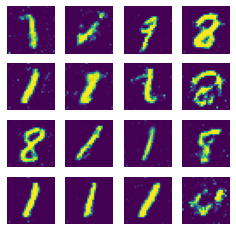

Epoch:  83


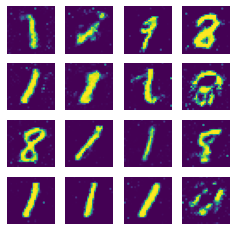

Epoch:  84


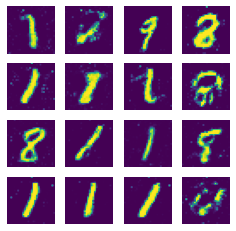

Epoch:  85


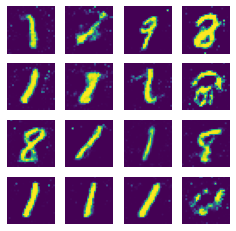

Epoch:  86


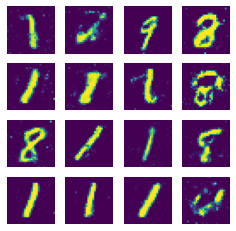

Epoch:  87


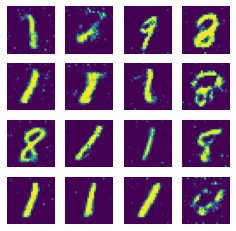

Epoch:  88


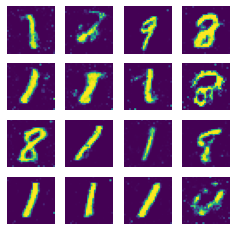

Epoch:  89


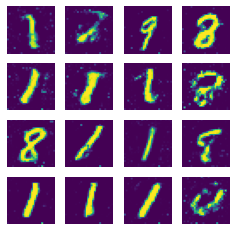

Epoch:  90


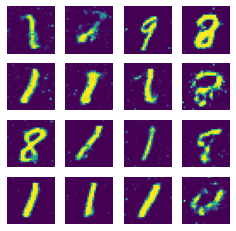

Epoch:  91


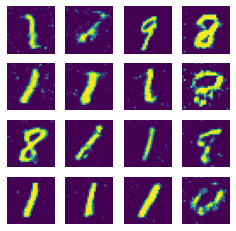

Epoch:  92


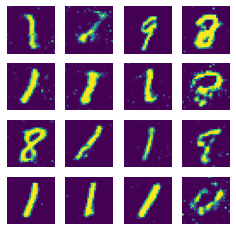

Epoch:  93


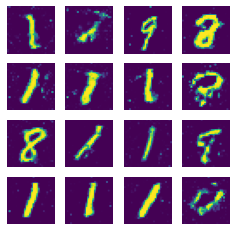

Epoch:  94


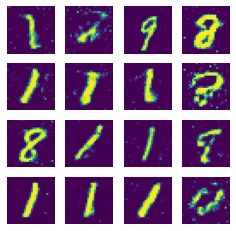

Epoch:  95


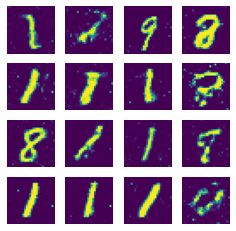

Epoch:  96


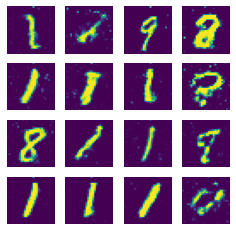

Epoch:  97


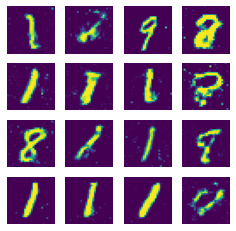

Epoch:  98


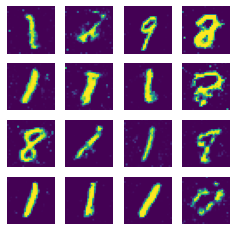

Epoch:  99


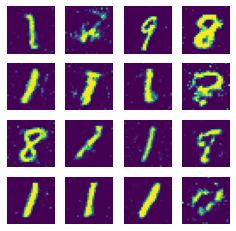

In [7]:
D_loss = []
G_loss = []
epochs = 100
for epoch in range(epochs):
    d_epoch_loss = 0
    g_epoch_loss = 0
    count = len(dataloader) # 一个epoch的大小
    for step, (img, _) in enumerate(dataloader):
        img = img.to(device) # 一个批次的图片
        size = img.size(0)   # 和和图片对应的原始噪音
        random_noise = torch.randn(size, 100, device=device)
        gen_img = gen(random_noise) # 生成的图像
 
        d_opt.zero_grad()
        real_output = dis(img)  # 判别器输入真实图片，对真实图片的预测结果，希望是1
        # 判别器在真实图像上的损失
        d_real_loss = loss(real_output, torch.ones_like(real_output)) # size一样全一的tensor
        d_real_loss.backward()
 
        g_opt.zero_grad()
        # 记得切断生成器的梯度
        fake_output = dis(gen_img.detach()) # 判别器输入生成图片，对生成图片的预测结果，希望是0
        # 判别器在生成图像上的损失
        d_fake_loss = loss(fake_output, torch.zeros_like(fake_output)) # size一样全一的tensor
        d_fake_loss.backward()
        
        d_loss = d_real_loss + d_fake_loss
        d_opt.step()
        
        
        # 生成器的损失
        g_opt.zero_grad()
        fake_output = dis(gen_img) # 希望被判定为1
        g_loss = loss(fake_output, torch.ones_like(fake_output))
        g_loss.backward()
        g_opt.step()
        
        # 每个epoch内的loss累加，循环外再除epoch大小，得到平均loss
        with torch.no_grad():
            d_epoch_loss += d_loss
            g_epoch_loss += g_loss
    # 一个epoch训练完成
    with torch.no_grad():
        d_epoch_loss /= count
        g_epoch_loss /= count
        D_loss.append(d_epoch_loss)
        G_loss.append(g_epoch_loss)
        print('Epoch: ',epoch)
        gen_img_plot(gen, test_input)

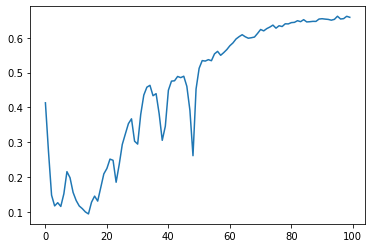

In [8]:
d_curve = [i.cpu() for i in D_loss]
plt.plot(d_curve)

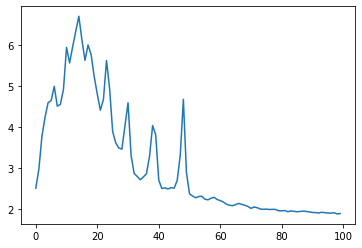

In [9]:
g_curve = [i.cpu() for i in G_loss]
plt.plot(g_curve)

In [1]:
#导入库
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data
import torchvision #加载图片
from torchvision import transforms #图片变换
 
import numpy as np
import matplotlib.pyplot as plt #绘图
import os
import glob
from PIL import Image

In [2]:
#独热编码
def one_hot(x,class_count=10):
    return torch.eye(class_count)[x,:]
 
transform = transforms.Compose([
    transforms.ToTensor(), #取值范围会被归一化到（0，1）之间
    transforms.Normalize(mean=0.5,std=0.5) #设置均值和方差均为0.5
])

dataset = torchvision.datasets.MNIST('/home/dhz/MNIST/',
                                    train=True,
                                    transform=transform,
                                    target_transform = one_hot,
                                    download = True)
dl = torch.utils.data.DataLoader(dataset,batch_size=64,shuffle = True)

In [3]:
#定义生成器
class Generator(nn.Module):
    def __init__(self):
        super(Generator,self).__init__()
        self.linear1 = nn.Linear(100,128*7*7)
        self.bn1=nn.BatchNorm1d(128*7*7)
        self.linear2 = nn.Linear(10,128*7*7)
        self.bn2=nn.BatchNorm1d(128*7*7)
        
        self.deconv1 = nn.ConvTranspose2d(256,128,
                                         kernel_size=(3,3),
                                         stride=1,
                                         padding=1)  #生成（128，7，7）的二维图像
        self.bn3=nn.BatchNorm2d(128)
        self.deconv2 = nn.ConvTranspose2d(128,64,
                                         kernel_size=(4,4),
                                         stride=2,
                                         padding=1)  #生成（64，14，14）的二维图像
        self.bn4=nn.BatchNorm2d(64)
        self.deconv3 = nn.ConvTranspose2d(64,1,
                                         kernel_size=(4,4),
                                         stride=2,
                                         padding=1)  #生成（1,28,28）的二维图像
        
    def forward(self,x1,x2):
        x1=F.relu(self.linear1(x1))
        x1=self.bn1(x1)
        x1=x1.view(-1,128,7,7)
        x2=F.relu(self.linear2(x2))
        x2=self.bn2(x2)
        x2=x2.view(-1,128,7,7)
        x=torch.cat([x1,x2],axis=1)  #batch, 256, 7, 7
        x=x.view(-1,256,7,7)
        x=F.relu(self.deconv1(x))
        x=self.bn3(x)
        x=F.relu(self.deconv2(x))
        x=self.bn4(x)
        x=torch.tanh(self.deconv3(x))
        return x

In [4]:
#定义判别器
#输入：1，28，28图片和长度为10的condition
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator,self).__init__()
        self.linear = nn.Linear(10,1*28*28)
        self.conv1 = nn.Conv2d(2,64,kernel_size=3,stride=2)
        self.conv2 = nn.Conv2d(64,128,kernel_size=3,stride=2)
        self.bn = nn.BatchNorm2d(128)
        self.fc = nn.Linear(128*6*6,1)
    def forward(self,x1,x2): #x1代表label,x2代表image
        x1=F.leaky_relu(self.linear(x1))
        x1=x1.view(-1,1,28,28)
        x=torch.cat([x1,x2],axis=1)  #shape:batch,2,28,28                
        x= F.dropout2d(F.leaky_relu(self.conv1(x)))
        x= F.dropout2d(F.leaky_relu(self.conv2(x)) )  #(batch,128,6,6)
        x = self.bn(x)
        x = x.view(-1,128*6*6) #展平
        x = torch.sigmoid(self.fc(x))
        return x

In [5]:
# 模型训练
#设备的配置
device='cuda' if torch.cuda.is_available() else 'cpu'
#初化生成器和判别器把他们放到相应的设备上
gen = Generator().to(device)
dis = Discriminator().to(device)
#交叉熵损失函数
loss_fn = torch.nn.BCELoss()
#训练器的优化器
d_optimizer = torch.optim.Adam(dis.parameters(),lr=1e-5)
#训练生成器的优化器
g_optimizer = torch.optim.Adam(gen.parameters(),lr=1e-4)

In [6]:
#定义可视化函数
def generate_and_save_images(model,epoch,label_input,noise_input):
    prediction = np.squeeze(model(noise_input,label_input).cpu().numpy())
    fig = plt.figure(figsize=(4,4))
    for i in range(prediction.shape[0]):
        plt.subplot(4,4,i+1)
        plt.imshow((prediction[i]+1)/2,cmap='gray')
        plt.axis('off')
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

In [7]:
#设置生成绘图图片的随机张量，这里可视化16张图片
#生成16个长度为100的随机正态分布张量
noise_seed = torch.randn(16,100,device=device)
label_seed = torch.randint(0,10,size=(16,))
label_seed_onehot = one_hot(label_seed).to(device)
 
D_loss = [] #记录训练过程中判别器的损失
G_loss = [] #记录训练过程中生成器的损失

Epoch: 0
tensor([1, 6, 4, 9, 0, 6, 3, 6, 5, 5, 6, 6, 7, 2, 3, 2])


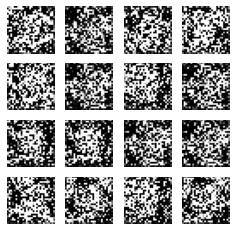

Epoch: 1
tensor([1, 6, 4, 9, 0, 6, 3, 6, 5, 5, 6, 6, 7, 2, 3, 2])


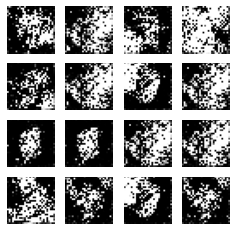

Epoch: 2
tensor([1, 6, 4, 9, 0, 6, 3, 6, 5, 5, 6, 6, 7, 2, 3, 2])


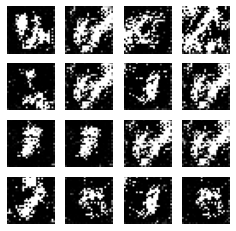

Epoch: 3
tensor([1, 6, 4, 9, 0, 6, 3, 6, 5, 5, 6, 6, 7, 2, 3, 2])


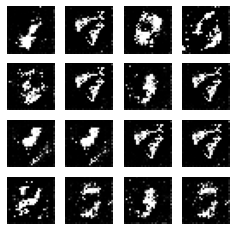

Epoch: 4
tensor([1, 6, 4, 9, 0, 6, 3, 6, 5, 5, 6, 6, 7, 2, 3, 2])


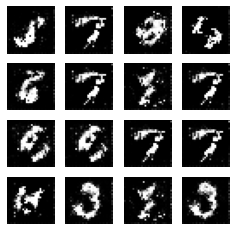

Epoch: 5
tensor([1, 6, 4, 9, 0, 6, 3, 6, 5, 5, 6, 6, 7, 2, 3, 2])


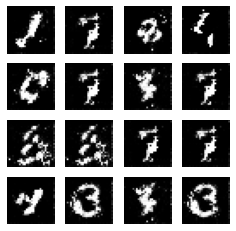

Epoch: 6
tensor([1, 6, 4, 9, 0, 6, 3, 6, 5, 5, 6, 6, 7, 2, 3, 2])


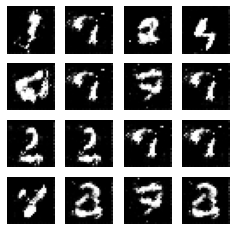

Epoch: 7
tensor([1, 6, 4, 9, 0, 6, 3, 6, 5, 5, 6, 6, 7, 2, 3, 2])


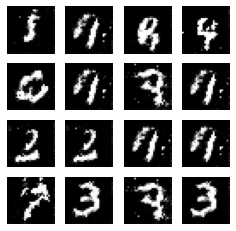

Epoch: 8
tensor([1, 6, 4, 9, 0, 6, 3, 6, 5, 5, 6, 6, 7, 2, 3, 2])


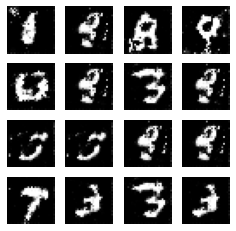

Epoch: 9
tensor([1, 6, 4, 9, 0, 6, 3, 6, 5, 5, 6, 6, 7, 2, 3, 2])


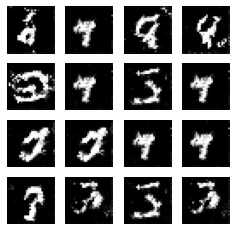

In [8]:
#训练循环
for epoch in range(10):
    #初始化损失值
    D_epoch_loss = 0
    G_epoch_loss = 0
    count = len(dl.dataset) #返回批次数
    #对数据集进行迭代
    for step,(img,label) in enumerate(dl):
        img =img.to(device) #把数据放到设备上
        label = label.to(device)
        size = img.shape[0] #img的第一位是size,获取批次的大小
        random_seed = torch.randn(size,100,device=device)
        
        #判别器训练(真实图片的损失和生成图片的损失),损失的构建和优化
        d_optimizer.zero_grad()#梯度归零
        #判别器对于真实图片产生的损失
        real_output = dis(label,img) #判别器输入真实的图片，real_output对真实图片的预测结果
        d_real_loss = loss_fn(real_output,
                              torch.ones_like(real_output,device=device)
                              )
        d_real_loss.backward()#计算梯度
        
        #在生成器上去计算生成器的损失，优化目标是判别器上的参数
        generated_img = gen(random_seed,label) #得到生成的图片
        #因为优化目标是判别器，所以对生成器上的优化目标进行截断
        fake_output = dis(label,generated_img.detach()) #判别器输入生成的图片，fake_output对生成图片的预测;detach会截断梯度，梯度就不会再传递到gen模型中了
        #判别器在生成图像上产生的损失
        d_fake_loss = loss_fn(fake_output,
                              torch.zeros_like(fake_output,device=device)
                              )
        d_fake_loss.backward()
        #判别器损失
        disc_loss = d_real_loss + d_fake_loss
        #判别器优化
        d_optimizer.step()
        
        
        #生成器上损失的构建和优化
        g_optimizer.zero_grad() #先将生成器上的梯度置零
        fake_output = dis(label,generated_img)
        gen_loss = loss_fn(fake_output,
                              torch.ones_like(fake_output,device=device)
                          )  #生成器损失
        gen_loss.backward()
        g_optimizer.step()
        #累计每一个批次的loss
        with torch.no_grad():
            D_epoch_loss +=disc_loss
            G_epoch_loss +=gen_loss
    #求平均损失
    with torch.no_grad():
            D_epoch_loss /=count
            G_epoch_loss /=count
            D_loss.append(D_epoch_loss)
            G_loss.append(G_epoch_loss)
            #训练完一个Epoch,打印提示并绘制生成的图片
            print("Epoch:",epoch)
            print(label_seed)
            generate_and_save_images(gen,epoch,label_seed_onehot,noise_seed)

Epoch [0/10000], D_loss: 1.5554, G_loss: 0.3788
Epoch [100/10000], D_loss: 1.5161, G_loss: 0.4117
Epoch [200/10000], D_loss: 1.4572, G_loss: 0.4578
Epoch [300/10000], D_loss: 1.4245, G_loss: 0.4983
Epoch [400/10000], D_loss: 1.4226, G_loss: 0.5268
Epoch [500/10000], D_loss: 1.4184, G_loss: 0.5457
Epoch [600/10000], D_loss: 1.4191, G_loss: 0.5637
Epoch [700/10000], D_loss: 1.4028, G_loss: 0.5875
Epoch [800/10000], D_loss: 1.3930, G_loss: 0.6153
Epoch [900/10000], D_loss: 1.3828, G_loss: 0.6400
Epoch [1000/10000], D_loss: 1.3850, G_loss: 0.6524
Epoch [1100/10000], D_loss: 1.3923, G_loss: 0.6556
Epoch [1200/10000], D_loss: 1.3954, G_loss: 0.6638
Epoch [1300/10000], D_loss: 1.3867, G_loss: 0.6763
Epoch [1400/10000], D_loss: 1.3816, G_loss: 0.6857
Epoch [1500/10000], D_loss: 1.3850, G_loss: 0.6888
Epoch [1600/10000], D_loss: 1.3878, G_loss: 0.6855
Epoch [1700/10000], D_loss: 1.3871, G_loss: 0.6894
Epoch [1800/10000], D_loss: 1.3869, G_loss: 0.6932
Epoch [1900/10000], D_loss: 1.3875, G_loss:

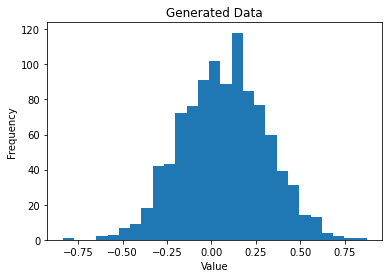

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Define the generator network
class Generator(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Generator, self).__init__()
        self.fc = nn.Linear(input_dim, output_dim)
        
    def forward(self, x):
        x = self.fc(x)
        return x

# Define the discriminator network
class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.fc = nn.Linear(input_dim, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.fc(x)
        x = self.sigmoid(x)
        return x

# Define the hyperparameters
input_dim = 10  # Dimension of the input noise vector
output_dim = 1  # Dimension of the generated vector
lr = 0.001  # Learning rate
num_epochs = 10000
batch_size = 128

# Initialize the generator and discriminator networks
generator = Generator(input_dim, output_dim)
discriminator = Discriminator(output_dim)

# Define the loss function
loss_fn = nn.BCELoss()

# Define the optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=lr)
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr)

# Training loop
for epoch in range(num_epochs):
    # Generate random noise vectors
    z = torch.randn(batch_size, input_dim)
    
    # Generate fake data samples
    fake_data = generator(z)
    
    # Train the discriminator
    optimizer_D.zero_grad()
    
    # Real data
    real_data = torch.randn(batch_size, output_dim)
    real_labels = torch.ones(batch_size, 1)
    real_output = discriminator(real_data)
    real_loss = loss_fn(real_output, real_labels)
    
    # Fake data
    fake_labels = torch.zeros(batch_size, 1)
    fake_output = discriminator(fake_data.detach())
    fake_loss = loss_fn(fake_output, fake_labels)
    
    # Total discriminator loss
    D_loss = real_loss + fake_loss
    D_loss.backward()
    optimizer_D.step()
    
    # Train the generator
    optimizer_G.zero_grad()
    fake_output = discriminator(fake_data)
    G_loss = loss_fn(fake_output, real_labels)
    G_loss.backward()
    optimizer_G.step()
    
    # Print training progress
    if epoch % 100 == 0:
        print(f"Epoch [{epoch}/{num_epochs}], D_loss: {D_loss.item():.4f}, G_loss: {G_loss.item():.4f}")

# Generate samples from the generator
num_samples = 1000
z = torch.randn(num_samples, input_dim)
generated_data = generator(z).detach().numpy()

# Plot the generated data
plt.hist(generated_data, bins='auto')
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.title("Generated Data")
plt.show()


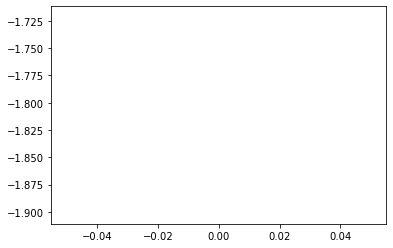

In [13]:
plt.plot(real_data.tolist()[0])

Epoch [0/10000], D_loss: 1.4943, G_loss: 0.3787
Epoch [100/10000], D_loss: 1.4659, G_loss: 0.3971
Epoch [200/10000], D_loss: 1.4565, G_loss: 0.4158
Epoch [300/10000], D_loss: 1.4393, G_loss: 0.4516
Epoch [400/10000], D_loss: 1.4188, G_loss: 0.4962
Epoch [500/10000], D_loss: 1.4106, G_loss: 0.5287
Epoch [600/10000], D_loss: 1.4035, G_loss: 0.5605
Epoch [700/10000], D_loss: 1.3973, G_loss: 0.5816
Epoch [800/10000], D_loss: 1.3927, G_loss: 0.5984
Epoch [900/10000], D_loss: 1.3896, G_loss: 0.6181
Epoch [1000/10000], D_loss: 1.3885, G_loss: 0.6358
Epoch [1100/10000], D_loss: 1.3873, G_loss: 0.6515
Epoch [1200/10000], D_loss: 1.3868, G_loss: 0.6655
Epoch [1300/10000], D_loss: 1.3868, G_loss: 0.6728
Epoch [1400/10000], D_loss: 1.3864, G_loss: 0.6780
Epoch [1500/10000], D_loss: 1.3863, G_loss: 0.6845
Epoch [1600/10000], D_loss: 1.3862, G_loss: 0.6865
Epoch [1700/10000], D_loss: 1.3863, G_loss: 0.6907
Epoch [1800/10000], D_loss: 1.3863, G_loss: 0.6914
Epoch [1900/10000], D_loss: 1.3863, G_loss:

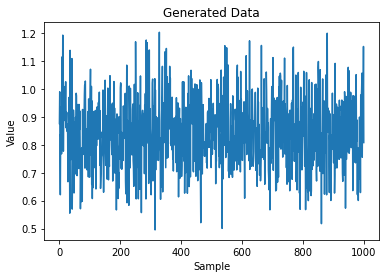

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Define the generator network
class Generator(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Generator, self).__init__()
        self.fc = nn.Linear(input_dim, output_dim)
        
    def forward(self, x):
        x = self.fc(x)
        return x

# Define the discriminator network
class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.fc = nn.Linear(input_dim, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.fc(x)
        x = self.sigmoid(x)
        return x

# Define the hyperparameters
input_dim = 10  # Dimension of the input noise vector
output_dim = 1  # Dimension of the generated vector
lr = 0.001  # Learning rate
num_epochs = 10000
batch_size = 128

# Initialize the generator and discriminator networks
generator = Generator(input_dim, output_dim)
discriminator = Discriminator(output_dim)

# Define the loss function
loss_fn = nn.BCELoss()

# Define the optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=lr)
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr)

# Training loop
for epoch in range(num_epochs):
    # Generate random noise vectors
    z = torch.randn(batch_size, input_dim)
    
    # Generate fake data samples
    fake_data = generator(z)
    
    # Train the discriminator
    optimizer_D.zero_grad()
    
    # Real data
    real_data = torch.ones(batch_size, output_dim)
    real_labels = torch.ones(batch_size, 1)
    real_output = discriminator(real_data)
    real_loss = loss_fn(real_output, real_labels)
    
    # Fake data
    fake_labels = torch.zeros(batch_size, 1)
    fake_output = discriminator(fake_data.detach())
    fake_loss = loss_fn(fake_output, fake_labels)
    
    # Total discriminator loss
    D_loss = real_loss + fake_loss
    D_loss.backward()
    optimizer_D.step()
    
    # Train the generator
    optimizer_G.zero_grad()
    fake_output = discriminator(fake_data)
    G_loss = loss_fn(fake_output, real_labels)
    G_loss.backward()
    optimizer_G.step()
    
    # Print training progress
    if epoch % 100 == 0:
        print(f"Epoch [{epoch}/{num_epochs}], D_loss: {D_loss.item():.4f}, G_loss: {G_loss.item():.4f}")

# Generate samples from the generator
num_samples = 1000
z = torch.randn(num_samples, input_dim)
generated_data = generator(z).detach().numpy()

# Plot the generated data
plt.plot(generated_data)
plt.xlabel("Sample")
plt.ylabel("Value")
plt.title("Generated Data")
plt.show()


/tmp/ipykernel_1868501/1695928317.py:51: DeprecationWarning: This function is deprecated. Please call randint(0, 100 + 1) instead
  bias = np.random.random_integers(low=0, high=100, size=128)


Epoch [0/50000], D_loss: 7.3319, G_loss: 67.5866
Epoch [100/50000], D_loss: 0.7580, G_loss: 36.9125
Epoch [200/50000], D_loss: 0.6959, G_loss: 14.1664
Epoch [300/50000], D_loss: 0.6736, G_loss: 3.8816
Epoch [400/50000], D_loss: 0.6367, G_loss: 1.7900
Epoch [500/50000], D_loss: 0.6086, G_loss: 1.2412
Epoch [600/50000], D_loss: 0.5795, G_loss: 1.0944
Epoch [700/50000], D_loss: 0.5359, G_loss: 1.0741
Epoch [800/50000], D_loss: 0.4903, G_loss: 1.1185
Epoch [900/50000], D_loss: 0.4559, G_loss: 1.1723
Epoch [1000/50000], D_loss: 0.4315, G_loss: 1.2211
Epoch [1100/50000], D_loss: 0.4096, G_loss: 1.2619
Epoch [1200/50000], D_loss: 0.3891, G_loss: 1.3023
Epoch [1300/50000], D_loss: 0.3736, G_loss: 1.3390
Epoch [1400/50000], D_loss: 0.3578, G_loss: 1.3803
Epoch [1500/50000], D_loss: 0.3447, G_loss: 1.4206
Epoch [1600/50000], D_loss: 0.3331, G_loss: 1.4589
Epoch [1700/50000], D_loss: 0.3227, G_loss: 1.4976
Epoch [1800/50000], D_loss: 0.3109, G_loss: 1.5435
Epoch [1900/50000], D_loss: 0.3007, G_lo

Epoch [16000/50000], D_loss: 0.4215, G_loss: 3.6384
Epoch [16100/50000], D_loss: 0.3426, G_loss: 3.6903
Epoch [16200/50000], D_loss: 0.2673, G_loss: 3.8616
Epoch [16300/50000], D_loss: 0.2804, G_loss: 4.0278
Epoch [16400/50000], D_loss: 0.3367, G_loss: 3.8598
Epoch [16500/50000], D_loss: 0.4515, G_loss: 3.7308
Epoch [16600/50000], D_loss: 0.4754, G_loss: 3.6517
Epoch [16700/50000], D_loss: 0.3324, G_loss: 3.7846
Epoch [16800/50000], D_loss: 0.2630, G_loss: 4.0254
Epoch [16900/50000], D_loss: 0.2440, G_loss: 4.2079
Epoch [17000/50000], D_loss: 0.2803, G_loss: 3.9934
Epoch [17100/50000], D_loss: 0.3972, G_loss: 3.7959
Epoch [17200/50000], D_loss: 0.4991, G_loss: 3.8278
Epoch [17300/50000], D_loss: 0.3651, G_loss: 3.8537
Epoch [17400/50000], D_loss: 0.3044, G_loss: 3.8245
Epoch [17500/50000], D_loss: 0.3279, G_loss: 3.8771
Epoch [17600/50000], D_loss: 0.2758, G_loss: 4.2270
Epoch [17700/50000], D_loss: 0.3281, G_loss: 4.0797
Epoch [17800/50000], D_loss: 0.4453, G_loss: 3.8615
Epoch [17900

Epoch [31800/50000], D_loss: 0.3455, G_loss: 3.9594
Epoch [31900/50000], D_loss: 0.3739, G_loss: 3.7853
Epoch [32000/50000], D_loss: 0.3745, G_loss: 3.5620
Epoch [32100/50000], D_loss: 0.3773, G_loss: 3.5886
Epoch [32200/50000], D_loss: 0.3398, G_loss: 3.6629
Epoch [32300/50000], D_loss: 0.3398, G_loss: 3.8468
Epoch [32400/50000], D_loss: 0.3480, G_loss: 3.6131
Epoch [32500/50000], D_loss: 0.3534, G_loss: 3.6784
Epoch [32600/50000], D_loss: 0.4170, G_loss: 3.5642
Epoch [32700/50000], D_loss: 0.4147, G_loss: 3.7691
Epoch [32800/50000], D_loss: 0.3061, G_loss: 3.8360
Epoch [32900/50000], D_loss: 0.2920, G_loss: 3.8128
Epoch [33000/50000], D_loss: 0.3504, G_loss: 3.5762
Epoch [33100/50000], D_loss: 0.3990, G_loss: 3.5934
Epoch [33200/50000], D_loss: 0.3774, G_loss: 3.6656
Epoch [33300/50000], D_loss: 0.3399, G_loss: 3.8335
Epoch [33400/50000], D_loss: 0.3646, G_loss: 3.8152
Epoch [33500/50000], D_loss: 0.3691, G_loss: 3.7347
Epoch [33600/50000], D_loss: 0.3737, G_loss: 3.6267
Epoch [33700

Epoch [47600/50000], D_loss: 0.3960, G_loss: 3.5703
Epoch [47700/50000], D_loss: 0.2714, G_loss: 3.7870
Epoch [47800/50000], D_loss: 0.3048, G_loss: 3.6514
Epoch [47900/50000], D_loss: 0.4025, G_loss: 3.4854
Epoch [48000/50000], D_loss: 0.4229, G_loss: 3.4425
Epoch [48100/50000], D_loss: 0.3483, G_loss: 3.4126
Epoch [48200/50000], D_loss: 0.3131, G_loss: 3.6324
Epoch [48300/50000], D_loss: 0.3810, G_loss: 3.5752
Epoch [48400/50000], D_loss: 0.4939, G_loss: 3.5963
Epoch [48500/50000], D_loss: 0.4691, G_loss: 3.7687
Epoch [48600/50000], D_loss: 0.2978, G_loss: 3.9147
Epoch [48700/50000], D_loss: 0.2529, G_loss: 3.9277
Epoch [48800/50000], D_loss: 0.3350, G_loss: 3.7126
Epoch [48900/50000], D_loss: 0.4443, G_loss: 3.4049
Epoch [49000/50000], D_loss: 0.5000, G_loss: 3.4586
Epoch [49100/50000], D_loss: 0.3090, G_loss: 3.6138
Epoch [49200/50000], D_loss: 0.2497, G_loss: 3.7350
Epoch [49300/50000], D_loss: 0.3477, G_loss: 3.6763
Epoch [49400/50000], D_loss: 0.4397, G_loss: 3.5430
Epoch [49500

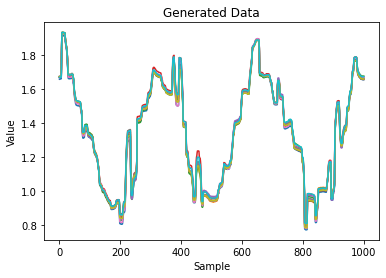

In [36]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

class ContinuityLoss(nn.Module):
    def __init__(self, weight=1.0):
        super(ContinuityLoss, self).__init__()
        self.weight = weight
        
    def forward(self, predictions):
        diff = predictions[:, 1:] - predictions[:, :-1]
        loss = torch.mean(torch.abs(diff))
        return loss * self.weight

# Define the generator network
class Generator(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Generator, self).__init__()
        self.fc = nn.Linear(input_dim, output_dim, bias=True)
        
    def forward(self, x):
        x = self.fc(x)
        return x

# Define the discriminator network
class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.fc = nn.Linear(input_dim, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.fc(x)
        x = self.sigmoid(x)
        return x

# Define the hyperparameters
input_dim = 10  # Dimension of the input noise vector
output_dim = 1000  # Dimension of the generated vector (ECG waveform)
lr = 0.001  # Learning rate
num_epochs = 50000
batch_size = 128

table = np.random.rand(128)
bias = np.random.random_integers(low=0, high=100, size=128)

# Define the real data (ECG waveform)
real_data = torch.tensor([table[i] * np.cos(np.linspace(0, 6 * np.pi, 1000)) + bias[i] for i in range(128)]).float()  # Provide your own ECG waveform data

# Initialize the generator and discriminator networks
generator = Generator(input_dim, output_dim)
discriminator = Discriminator(output_dim)

# Define the loss function
loss_fn = nn.BCELoss()
continue_loss = ContinuityLoss(weight=100.0)

# Define the optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=lr)
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr)

# Training loop
for epoch in range(num_epochs):
    # Generate random noise vectors
    z = torch.randn(batch_size, input_dim)
    
    # Generate fake data samples
    fake_data = generator(z)
    
    # Train the discriminator
    optimizer_D.zero_grad()
    
    real_labels = torch.ones(batch_size, 1)
    real_output = discriminator(real_data)
    real_loss = loss_fn(real_output, real_labels)
    
    fake_labels = torch.zeros(batch_size, 1)
    fake_output = discriminator(fake_data.detach())
    fake_loss = loss_fn(fake_output, fake_labels)
    
    D_loss = real_loss + fake_loss
    D_loss.backward()
    optimizer_D.step()
    
    # Train the generator
    optimizer_G.zero_grad()
    fake_output = discriminator(fake_data)
    G_loss = loss_fn(fake_output, real_labels) + continue_loss(fake_data)
    G_loss.backward()
    optimizer_G.step()
    
    # Print training progress
    if epoch % 100 == 0:
        print(f"Epoch [{epoch}/{num_epochs}], D_loss: {D_loss.item():.4f}, G_loss: {G_loss.item():.4f}")

# Generate samples from the generator
num_samples = 10
z = torch.randn(num_samples, input_dim)
generated_data = generator(z).detach().numpy()

# Plot the generated data
for i in range(num_samples):
    plt.plot(generated_data[i])
plt.xlabel("Sample")
plt.ylabel("Value")
plt.title("Generated Data")
plt.show()

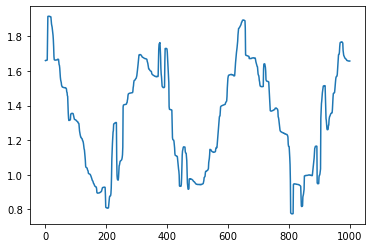

In [37]:
plt.plot(generated_data[0])

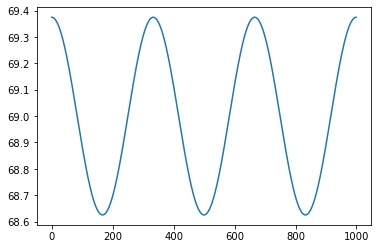

In [38]:
plt.plot(real_data[0])